#### Universidade Federal de Campina Grande
#### Departamento de Sistemas e Computação
#### Lucas Nascimento Cabral
#### Previsão de Eleição de Deputados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,situacao
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.67,0.0,...,14,14,16583.60,1184.54,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,nao_eleito
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.85,6625.0,...,24,23,20325.99,846.92,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,nao_eleito
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,158120.80,9301.22,2250.0,...,123,108,146011.70,1187.09,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,eleito
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.19,0.0,...,8,8,3001.12,375.14,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,nao_eleito
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,119820.00,2496.25,0.0,...,133,120,116416.64,875.31,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,eleito


In [3]:
y = train["situacao"]
y = y.replace(['nao_eleito', 'eleito'], [0, 1])

#removendo variável alvo dos dados de treino
train = train.drop(columns=['situacao'])
#merge treino e teste
data = pd.concat((train, test))

Atributos desnecessários como sequencial_candidato, media_receita, media_despesas e nome podem ser removidos.

In [4]:
data = data.drop(columns=['sequencial_candidato', 'nome', 'cargo',
                            'quantidade_doacoes', 'total_receita',
                            'quantidade_despesas', 'total_despesa'])

Aplicando normalização em todas as variáveis numéricas, exceto ano, por ser considerada como ordinal

In [5]:
#selecionando atributos numéricos
attr_num = data.dtypes[data.dtypes != "object"].index
#normalizando variáveis numéricas exceto ano
data[attr_num[1:]] = np.log1p(data[attr_num[1:]])

#dummy das variáveis categoricas
data = pd.get_dummies(data)

x = data.loc[data['ano'] != 2014]
test = data.loc[data['ano'] == 2014]

#### (1) Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? 

0    6596
1    1026
Name: situacao, dtype: int64

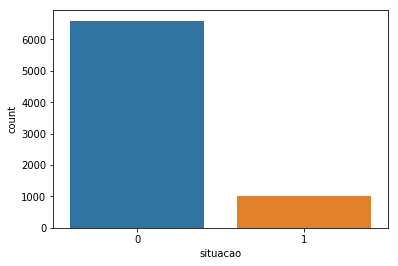

In [6]:
sns.countplot(y)

y.value_counts()

Como podemos observar em nosso conjunto de treino existe o desbalanceamento muito grande na quantidade de instâncias de cada classe, chegando a relação de instâncias nao_eleito para eleito igual a 86:14. Esse desbalanceamento pode levar nossos algoritmos de aprendizado de máquina a não conseguirem obter classificadores satisfatórios, porque apesar dos exemplos das classes majoritárias (de maior proporção) serem classificados corretamente com grande frequência, normalmente os exemplos das
classes minoritárias (de menor proporção) não são classificados corretamente.

Para resolver esse problema utilizamos técnicas de Under-sampling, neste laboratório vou utilizar Cluster Centroids. Essa técnica realiza subamostragem gerando centróides com base em métodos de agrupamento. Os dados serão previamente agrupados por semelhança, a fim de preservar a informação.

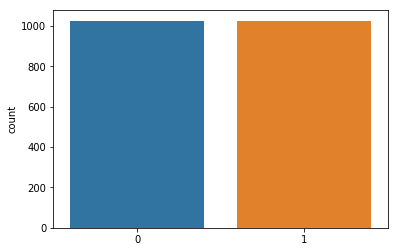

In [7]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
x_balanced, y_balanced = cc.fit_sample(x, y)

sns.countplot(y_balanced)

#### (2) Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo. 

Para isso, utilizamos a seguinte função para calcular o f1 na validação cruzada, que realiza um shuffle ao selecionar os folds, dado que o Cluster Centroide agrupa os dados em suas respectivas classes.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def f1_cv(model, x, y):
    f1 = cross_val_score(model, x, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=2432))
    return(f1)

#### (2.1) Regressão Logística

In [9]:
from sklearn.linear_model import LogisticRegression

alphas = np.arange(0.01,0.1,0.01).tolist()
cv_logRegression = [f1_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha),
                         x_balanced, 
                         y_balanced).mean()
                    for alpha in alphas]

cv_logRegression = pd.Series(cv_logRegression, index = alphas)

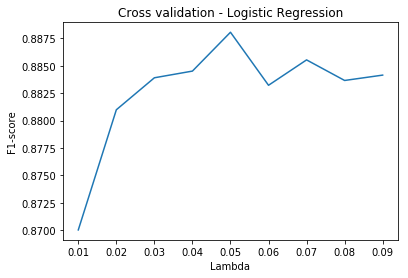

O melhor alpha é 0.05, com F1 = 0.8880521221543798


In [10]:
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

#### (2.2) KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

k_list = np.arange(15,40,1).tolist()

cv_knn = [f1_cv(KNeighborsClassifier(n_neighbors=n),
               x_balanced,
               y_balanced).mean() 
            for n in k_list]
cv_knn = pd.Series(cv_knn, index = k_list)

O melhor numero de vizinhos é 39, com F1 = 0.8496806793194901


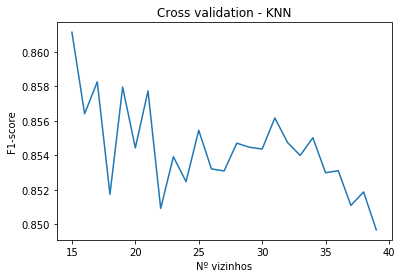

In [12]:
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")

print("O melhor numero de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmin(), cv_knn.min()))

#### (2.3) Árvore de decisão

In [13]:
from sklearn.tree import DecisionTreeClassifier

depths = np.arange(1,20,1).tolist()

cv_decisionTree = [f1_cv(DecisionTreeClassifier(max_depth = depth),
                x_balanced,
                y_balanced).mean() 
            for depth in depths]


cv_decisionTree = pd.Series(cv_decisionTree, index = depths)

A profundidade máxima ideal é 8, com F1 = 0.9288538668980408


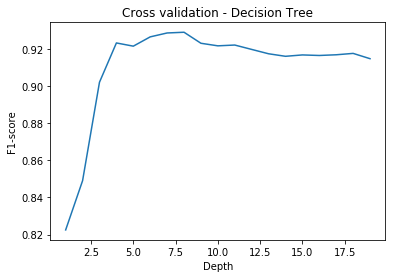

In [14]:
cv_decisionTree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")

print("A profundidade máxima ideal é {0}, com F1 = {1}".format(cv_decisionTree.idxmax(), cv_decisionTree.max()))

#### (2.4) Adaboost

In [15]:
from sklearn.ensemble import AdaBoostClassifier

estimators = np.arange(30,80,1).tolist()

cv_adaboost = [f1_cv(AdaBoostClassifier(DecisionTreeClassifier(max_depth= 1),
                         algorithm="SAMME",
                         n_estimators=e),
                    x_balanced,
                    y_balanced).mean()
                  for e in estimators]


cv_adaboost = pd.Series(cv_adaboost, index = estimators)

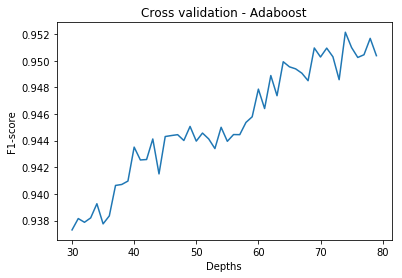

O melhor numero de estimadores é 74, com F1 = 0.9521463699280165


In [16]:
cv_adaboost.plot(title = "Cross validation - Adaboost")
plt.xlabel("Depths")
plt.ylabel("F1-score")
plt.show()

print("O melhor numero de estimadores é {0}, com F1 = {1}".format(cv_adaboost.idxmax(), cv_adaboost.max()))

#### (3) Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)

#### (4) Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)

#### (5) Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo:

#### (5.1) Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).

#### (5.1.1) Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

trees = np.arange(50,150,1).tolist()
cv_random_forest = [f1_cv(RandomForestClassifier(n_estimators=tree, max_depth=cv_decisionTree.idxmax(), random_state=0),
                         x_balanced,
                         y_balanced).mean() 
                    for tree in trees]

cv_random_forest = pd.Series(cv_random_forest, index = trees)

A quantidade de árvores ideal é 143, com F1 = 0.945761595242024


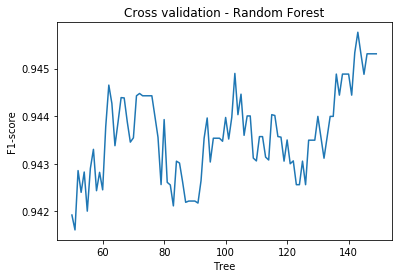

In [19]:
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Tree")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

#### (5.1.2) Ridge

In [20]:
from sklearn.linear_model import RidgeClassifier

alphas = np.arange(50,100,0.1).tolist()
cv_ridge = [f1_cv(RidgeClassifier(alpha = alpha),
                          x_balanced, 
                          y_balanced).mean()
                    for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)

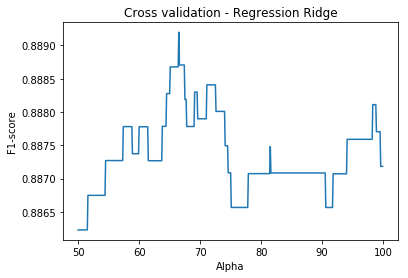

O melhor alpha é 66.50000000000023, com F1 = 0.8891984970526569


In [21]:
cv_ridge.plot(title = "Cross validation - Regression Ridge")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_ridge.idxmax(), cv_ridge.max()))

#### Para analisarmos qual o melhor modelo, construimos o seguinte método:

In [22]:
def evaluate_model(model):
    model.fit(x_balanced, y_balanced)
    print("\n%s\n"% (metrics.classification_report(y, model.predict(x))))
    # print( metrics.classification_report(y, model.predict(x), output_dict=True)["macro avg"]["f1-score"])

Executamos o método para todos os modelos criados anteriormente:

In [23]:
reg_log = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegression.idxmax(), random_state=1)
print("Classification report for classifier linear regression:")
evaluate_model(reg_log)

knn = KNeighborsClassifier(n_neighbors=cv_knn.idxmax())
print("Classification report for classifier KNN:")
evaluate_model(knn)

tree = DecisionTreeClassifier(max_depth=cv_decisionTree.idxmax())
print("Classification report for classifier Decision Tree:")
evaluate_model(tree)

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_decisionTree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=cv_adaboost.idxmax())
print("Classification report for classifier Adaboost:")
evaluate_model(ada)


random_forest = RandomForestClassifier(n_estimators=cv_random_forest.idxmax(), max_depth=cv_decisionTree.idxmax(), 
                                       random_state=10)
print("Classification report for classifier Rando Forest:")
evaluate_model(random_forest)

ridge = RidgeClassifier(alpha=cv_ridge.idxmax())
print("Classification report for classifier Ridge:")
evaluate_model(ridge)

Classification report for classifier linear regression:

             precision    recall  f1-score   support

          0       0.99      0.89      0.94      6596
          1       0.57      0.93      0.71      1026

avg / total       0.93      0.90      0.91      7622


Classification report for classifier KNN:

             precision    recall  f1-score   support

          0       0.98      0.90      0.94      6596
          1       0.58      0.89      0.70      1026

avg / total       0.93      0.90      0.91      7622


Classification report for classifier Decision Tree:

             precision    recall  f1-score   support

          0       1.00      0.79      0.88      6596
          1       0.42      0.99      0.59      1026

avg / total       0.92      0.82      0.84      7622


Classification report for classifier Adaboost:

             precision    recall  f1-score   support

          0       1.00      0.78      0.88      6596
          1       0.42      1.00      0.59  

Ao final, obtivemos os seguintes resultados para os modelos construidos:


|    Modelo      |         classification_report          | 
|----------------|----------------------------------------|
|    Logistic    |           0.7898396993630391           |  
|      KNN       |           0.7898396993630391           | 
|      Tree      |           0.7898396993630391           |    
|    Adaboost    |           0.7898396993630391           |  
|  Random Forest |           0.7898396993630391           |   
|     Ridge      |           0.7898396993630391           |   

#### (5.3) Experimente balancear as classes,  caso estejam desbalanceadas.

Como visto anteriormente no tópico (1), as classes estavam desbalanceadas, mas para resolver isso, utilizamos uma técnica de Under-sampling, Cluster Centroids. Essa técnica realiza subamostragem gerando centróides com base em métodos de agrupamento. Os dados foram previamente agrupados por semelhança, a fim de preservar a informação.

#### Para gerar o documento de submissão, utilizaremos o seguinte método:

In [30]:
submission = pd.read_csv("sample_submission.csv")
m = RandomForestClassifier(n_estimators=cv_random_forest.idxmax(), max_depth=cv_decisionTree.idxmax(), 
                                       random_state=10)
m.fit(x_balanced, y_balanced)

predicts_submission = pd.DataFrame(m.predict(test))
predicts_submission = predicts_submission.replace([0, 1],['nao_eleito', 'eleito'])
submission["Predicted"] = predicts_submission
submission.to_csv("my_submission.csv")